# Aggregation of Power System Optimization Models - Part II

There is an optimal way of doing this aggregation for this model using the basis oriented approach.

### Marginal Costs
Let us have a look to the marginal costs in the complete solution

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import testbed

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# We can export the variables, first create a folder and then export the results
slvr = 'glpk'     # change according to the solver installed in your machine

results_complete = testbed.run_complete_case(folder='data', case='complete_single_node.xlsx', solver=slvr)
# exporting the solution
df_complete = testbed.export_complete_solution(results_complete, 'complete_single_node')
# exporting the duals
df_complete_duals = testbed.extract_duals(model=results_complete, folder='complete_single_node')
marginal_costs = df_complete_duals.drop(columns=['period']).drop_duplicates()['eBalance']
marginal_costs

0       24.0
3        3.0
59    5000.0
Name: eBalance, dtype: float64

### Grouping the Hours
Now let's group together the hours with the same marginal cost

In [3]:
# this is not the best way, but a quick and dirty one
df_cf = pd.read_excel(os.path.join('data', 'complete_single_node.xlsx'), sheet_name='cap_factors')
df_demand = pd.read_excel(os.path.join('data', 'complete_single_node.xlsx'), sheet_name='demand')
df_input = pd.merge(left=df_demand, left_on='period', right=df_cf, right_on='period')

i = 1
df_input_copy = df_input.copy()
df_input_copy['basis'] = ''
df_input_copy['weight'] = 0
basis_w = []
for mc in marginal_costs:
    idx_basis = df_complete_duals.eBalance == mc
    df_input_copy.loc[idx_basis, 'basis'] = i
    df_input_copy.loc[idx_basis, 'weight'] = idx_basis.sum()
    i = i + 1

### Centroid Calculation
For each of these groups, calculate a centroid

In [4]:
df_basis_centroids = df_input_copy.groupby('basis').agg({'cap_factor': ['mean'],'demand': ['mean'], 'weight': ['max']})
df_basis_centroids.reset_index(drop=False, inplace=True) # to have the week as a data column and not as index
df_basis_centroids.columns = ['_'.join(col) for col in df_basis_centroids.columns]
df_basis_centroids = df_basis_centroids.rename(columns={'cap_factor_mean': 'cap_factor', 'demand_mean':'demand', 'weight_max':'weight'}).drop(columns=['basis_'])

### Aggregated Model
Create an aggregated model using the centroids, in this case the weights are the number of hours that correspond to that marginal cost

In [5]:
df_config_ext = testbed.generate_config(df_basis_centroids, folder='aggregated_single_ext')
df_basis_centroids

,cap_factor,demand,weight
0,0.294883,406.973032,6271
1,0.655851,221.598184,964
2,0.141925,656.143712,1501


### Running the Models
Now is time to run the aggregated and compare its results with the complete one

In [6]:
results = testbed.basis_execution(folder=os.path.join('data', 'aggregated_single_ext'), # location of the aggregated model
                                  solver=slvr, file='config_auto.xlsx')              # configuration file with aggregation information
df_agg_ext = testbed.export_aggregated_solution(results, 'aggregated_single_ext')
df_comparison_ext = testbed.export_model_comparison(df_complete, df_agg_ext)
df_comparison_ext


,result,complete,aggregated,delta,rel_delta
0,of_value,7.000903e+08,7.000903e+08,-1.072884e-06,-1.554312e-15
1,thermal,2.378023e+06,2.378023e+06,5.587935e-09,2.331468e-15
2,renewable,1.244741e+06,1.244741e+06,-2.328306e-10,-2.220446e-16
3,nsp,1.278567e+05,1.278567e+05,5.820766e-11,4.440892e-16
4,decision_vars,2.620800e+04,9.000000e+00,2.619900e+04,9.996566e-01


## How does that solution look in the input space?

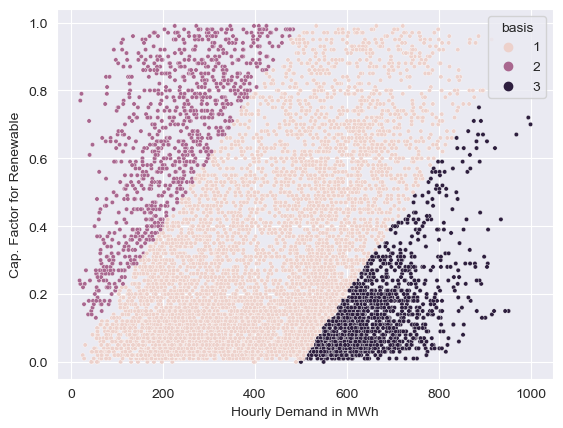

In [7]:
ax = sns.scatterplot(df_input_copy, x='demand', y='cap_factor', hue=df_input_copy['basis'], s=10)
ax.set_ylabel('Cap. Factor for Renewable')
ax.set_xlabel('Hourly Demand in MWh')
plt.show()